## This Notebook is purely to recreate the models and graphs for the report

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from functools import reduce
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import textwrap

In [7]:
forecastdemand_vic = pd.read_csv("../data/Australia/a/forecastdemand_vic.csv")
forecastdemand_sa = pd.read_csv("../data/Australia/b/forecastdemand_sa.csv")
forecastdemand_qld = pd.read_csv("../data/Australia/c/forecastdemand_qld.csv")
temperature_qld = pd.read_csv("../data/Australia/d/temprature_qld.csv")  # There's a typo in 'temperature' in the file path
temperature_sa = pd.read_csv("../data/Australia/d/temprature_sa.csv")  # Same typo as above
temperature_vic = pd.read_csv("../data/Australia/d/temprature_vic.csv")  # Same typo as above
totaldemand_qld = pd.read_csv("../data/Australia/d/totaldemand_qld.csv")
totaldemand_sa = pd.read_csv("../data/Australia/d/totaldemand_sa.csv")
totaldemand_vic = pd.read_csv("../data/Australia/d/totaldemand_vic.csv")

In [8]:
forecastdemand_qld['DATETIME'] = pd.to_datetime(forecastdemand_qld['DATETIME'], format="%Y-%m-%d %H:%M:%S")
temperature_qld['DATETIME'] = pd.to_datetime(temperature_qld['DATETIME'], format="%d/%m/%Y %H:%M")
totaldemand_qld['DATETIME'] = pd.to_datetime(totaldemand_qld['DATETIME'], format="%Y-%m-%d %H:%M:%S")

In [9]:
forecastdemand_qld['LASTCHANGED'] = pd.to_datetime(forecastdemand_qld['LASTCHANGED'])
forecastdemand_qld.sort_values(by='LASTCHANGED', ascending=False, inplace=True)
forecastdemand_qld.drop_duplicates(subset='DATETIME', keep='first', inplace=True)
print(forecastdemand_qld.shape)


(73833, 6)


In [12]:
dataframes_qld = [forecastdemand_qld, totaldemand_qld, temperature_qld]

for df in dataframes_qld:
    df['YEAR'] = df['DATETIME'].dt.year
    df['MONTH'] = df['DATETIME'].dt.month
    df['DAY'] = df['DATETIME'].dt.day
    df['HOUR'] = df['DATETIME'].dt.hour
    df['MINUTE'] = df['DATETIME'].dt.minute

merge_keys = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE']
df_qld_merged = reduce(lambda left, right: pd.merge(left, right, on=merge_keys, how='inner'), dataframes_qld)



In [13]:
df_qld_merged.drop(columns=['REGIONID_x', 'DATETIME_x'], inplace=True)
print(df_qld_merged.columns)

Index(['PREDISPATCHSEQNO', 'PERIODID', 'FORECASTDEMAND', 'LASTCHANGED', 'YEAR',
       'MONTH', 'DAY', 'HOUR', 'MINUTE', 'DATETIME_y', 'TOTALDEMAND',
       'REGIONID_y', 'LOCATION', 'DATETIME', 'TEMPERATURE'],
      dtype='object')


## Baseline Lin Reg Model BEFORE any feature engineering

In [16]:

X = df_qld_merged[['TEMPERATURE']]  # Predictor
y = df_qld_merged['TOTALDEMAND']     # Response variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_reg_model = LinearRegression()

lin_reg_model.fit(X_train, y_train)

y_pred = lin_reg_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

r_squared = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Coefficient of Determination (R^2): {r_squared}")


Mean Squared Error (MSE): 649170.1876800539
Coefficient of Determination (R^2): 0.18776729907172152


In [21]:

metrics_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'])

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'Linear Regression',
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print(metrics_df)



               Model           MSE        RMSE         MAE        R2
0  Linear Regression  649170.18768  805.710983  657.723842  0.187767


/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_18194/1133693258.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


## Adding in the Engineered Features

## Weekend and Season

In [22]:
df_qld_merged['is_weekend'] = df_qld_merged['DATETIME'].dt.dayofweek >= 5

df_qld_merged['season'] = df_qld_merged['DATETIME'].dt.month % 12 // 3
df_qld_merged['season'] = df_qld_merged['season'].map({0: 'Summer', 1: 'Autumn', 2: 'Winter', 3: 'Spring'}, na_action='ignore')


australian_seasons = {
    12: 'Summer', 1: 'Summer', 2: 'Summer',
    3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
    6: 'Winter', 7: 'Winter', 8: 'Winter',
    9: 'Spring', 10: 'Spring', 11: 'Spring'
    }
df_qld_merged['season'] = df_qld_merged['MONTH'].map(australian_seasons)

## Heating and Cooling Magnitudes,

In [23]:
df_qld_merged['Cooling'] = df_qld_merged['TEMPERATURE'].apply(lambda x: max(0, x - 24))

df_qld_merged['Heating'] = df_qld_merged['TEMPERATURE'].apply(lambda x: max(0, 20 - x))

print(df_qld_merged[['Cooling', 'Heating']].head())  

   Cooling  Heating
0      0.0      0.5
1      0.0      0.4
2      0.0      0.6
3      0.0      0.5
4      0.0      0.4


## Public Holidays

In [25]:
file_path = '../data/public_holidays/Aus_public_hols_2009-2022-1.csv'
try:
    public_holidays = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    public_holidays = pd.read_csv(file_path, encoding='latin1')

In [27]:
public_holidays['Date'] = pd.to_datetime(public_holidays['Date'])

In [29]:
public_holidays['Date'] = pd.to_datetime(public_holidays['Date'])
qld_holidays = public_holidays[public_holidays['State'] == 'QLD']
qld_holiday_dates = qld_holidays['Date'].dt.date.unique()
df_qld_merged['DATETIME'] = pd.to_datetime(df_qld_merged['DATETIME'])
df_qld_merged['Public_Holiday'] = df_qld_merged['DATETIME'].dt.date.isin(qld_holiday_dates).astype(int)


## Adding in Solar Feature

In [30]:
solar_PV_production = pd.read_csv('../data/PV_Data/raw_data/unzipped_data/combined_df_grouped_sorted.csv')

In [31]:
qld_solar_df = solar_PV_production[solar_PV_production['State'] == 'QLD']

In [32]:
qld_solar_df['INTERVAL_DATETIME'] = pd.to_datetime(qld_solar_df['INTERVAL_DATETIME'], infer_datetime_format=True)

/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_18194/730933358.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  qld_solar_df['INTERVAL_DATETIME'] = pd.to_datetime(qld_solar_df['INTERVAL_DATETIME'], infer_datetime_format=True)
/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_18194/730933358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qld_solar_df['INTERVAL_DATETIME'] = pd.to_datetime(qld_solar_df['INTERVAL_DATETIME'], infer_datetime_format=True)


In [33]:
complete_merged_df = df_qld_merged.merge(
    qld_solar_df[['INTERVAL_DATETIME', 'POWER']], 
    how='left', 
    left_on='DATETIME', 
    right_on='INTERVAL_DATETIME'
)

In [34]:
complete_merged_df.rename(columns={'POWER': 'Solar_Production'}, inplace=True)

In [35]:
complete_merged_df = complete_merged_df.dropna(subset=['INTERVAL_DATETIME', 'Solar_Production'])

## Lin Reg model with engineered features

In [38]:
numerical_features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'TEMPERATURE', 'Heating', 'Cooling', 'Solar_Production']
categorical_features = ['season']
binary_features = ['is_weekend', 'Public_Holiday']  

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X = complete_merged_df.drop(['TOTALDEMAND'], axis=1)
y = complete_merged_df['TOTALDEMAND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 239856.54902070353
R^2 Score: 0.6946786082629299


## Adding Predictions to the Entire DF

In [39]:
pipeline.fit(X, y)
complete_merged_df['Lin_Reg_Prediction'] = pipeline.predict(X)
complete_merged_df['Lin_Reg_Error'] = complete_merged_df['TOTALDEMAND'] - complete_merged_df['Lin_Reg_Prediction']
complete_merged_df['Lin_Reg_Error_Rate'] = complete_merged_df['Lin_Reg_Error'] / complete_merged_df['Lin_Reg_Prediction']
print(complete_merged_df[['TOTALDEMAND', 'Lin_Reg_Prediction', 'Lin_Reg_Error', 'Lin_Reg_Error_Rate']].head())

   TOTALDEMAND  Lin_Reg_Prediction  Lin_Reg_Error  Lin_Reg_Error_Rate
0      5737.03             5586.25         150.78            0.026991
1      5897.64             7037.75       -1140.11           -0.161999
2      6144.16             7034.00        -889.84           -0.126506
3      6264.63             6972.75        -708.12           -0.101555
4      6443.62             6975.00        -531.38           -0.076184


## Adding to metrics DF

In [44]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'Linear Regression with Engineered Features',
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print(metrics_df)

                                        Model            MSE        RMSE  \
0                           Linear Regression  649170.187680  805.710983   
1  Linear Regression with Engineered Features  239856.549021  489.751518   

          MAE        R2  
0  657.723842  0.187767  
1  395.372144  0.694679  


## Adding in the NN

In [45]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=2000, random_state=42))
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 26901.457627122916
R^2 Score: 0.9657562384016456


## Adding outputs from NN Model to Metrics DF

In [46]:
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'MLP with Engineered Features',
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print(metrics_df)

                                        Model            MSE        RMSE  \
0                           Linear Regression  649170.187680  805.710983   
1  Linear Regression with Engineered Features  239856.549021  489.751518   
2                MLP with Engineered Features   26901.457627  164.016638   

          MAE        R2  
0  657.723842  0.187767  
1  395.372144  0.694679  
2  118.092877  0.965756  


In [50]:
complete_merged_df['MLP_Prediction'] = pipeline.predict(X)
complete_merged_df['MLP_Error'] = complete_merged_df['TOTALDEMAND'] - complete_merged_df['MLP_Prediction']
complete_merged_df['MLP_Error_Rate'] = complete_merged_df['MLP_Error'] / complete_merged_df['MLP_Prediction']
complete_merged_df['MLP_Error_Rate'].replace([np.inf, -np.inf], np.nan, inplace=True)
# Display the relevant columns from the DataFrame for both MLP and Linear Regression models
print(complete_merged_df[['TOTALDEMAND', 
                          'MLP_Prediction', 'MLP_Error', 'MLP_Error_Rate',
                          'Lin_Reg_Prediction', 'Lin_Reg_Error', 'Lin_Reg_Error_Rate']].head())

   TOTALDEMAND  MLP_Prediction   MLP_Error  MLP_Error_Rate  \
0      5737.03     5833.110111  -96.080111       -0.016472   
1      5897.64     6213.036073 -315.396073       -0.050764   
2      6144.16     6391.496380 -247.336380       -0.038698   
3      6264.63     6443.568560 -178.938560       -0.027770   
4      6443.62     6587.435414 -143.815414       -0.021832   

   Lin_Reg_Prediction  Lin_Reg_Error  Lin_Reg_Error_Rate  
0             5586.25         150.78            0.026991  
1             7037.75       -1140.11           -0.161999  
2             7034.00        -889.84           -0.126506  
3             6972.75        -708.12           -0.101555  
4             6975.00        -531.38           -0.076184  


/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_18194/3075316677.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complete_merged_df['MLP_Error_Rate'].replace([np.inf, -np.inf], np.nan, inplace=True)


## The LSTM Model

In [53]:
numerical_features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'TEMPERATURE', 'Heating', 'Cooling', 'Solar_Production']
categorical_features = ['season']
binary_features = ['is_weekend', 'Public_Holiday']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

X = complete_merged_df.drop(['TOTALDEMAND'], axis=1)
y = complete_merged_df['TOTALDEMAND'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train.astype(np.float32))
y_train_tensor = torch.tensor(y_train.astype(np.float32))
X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_test_tensor = torch.tensor(y_test.astype(np.float32))

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64  # You can adjust this size
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [54]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Here x should have dimensions [batch, 1, features] - adding sequence dimension
        x = x.unsqueeze(1)  
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_dim = X_train.shape[1]  # number of features
hidden_dim = 100  # can be changed
num_layers = 2  # number of LSTM layers
output_dim = 1  # one output
num_epochs = 50
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [57]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # If using GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 36745444.0
Epoch 2, Loss: 35711904.0
Epoch 3, Loss: 21453370.0
Epoch 4, Loss: 15472523.0
Epoch 5, Loss: 14951879.0
Epoch 6, Loss: 11589080.0
Epoch 7, Loss: 10727099.0
Epoch 8, Loss: 7649738.0
Epoch 9, Loss: 4392349.5
Epoch 10, Loss: 4421031.5
Epoch 11, Loss: 3048632.25
Epoch 12, Loss: 638204.125
Epoch 13, Loss: 1568044.625
Epoch 14, Loss: 414685.34375
Epoch 15, Loss: 393818.28125
Epoch 16, Loss: 378428.625
Epoch 17, Loss: 565281.1875
Epoch 18, Loss: 21361.587890625
Epoch 19, Loss: 296748.65625
Epoch 20, Loss: 32029.65625
Epoch 21, Loss: 130100.03125
Epoch 22, Loss: 96901.8046875
Epoch 23, Loss: 62448.09375
Epoch 24, Loss: 23947.427734375
Epoch 25, Loss: 46091.921875
Epoch 26, Loss: 29302.5
Epoch 27, Loss: 14483.3623046875
Epoch 28, Loss: 12259.1025390625
Epoch 29, Loss: 12435.42578125
Epoch 30, Loss: 23949.376953125
Epoch 31, Loss: 19838.564453125
Epoch 32, Loss: 27975.150390625
Epoch 33, Loss: 37732.69921875
Epoch 34, Loss: 9450.6357421875
Epoch 35, Loss: 19635.30859375

In [58]:
model.eval()  # Set the model to evaluation mode
predictions = []
targets = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.view(-1).tolist())  # Flatten outputs to list
        targets.extend(labels.view(-1).tolist())  # Flatten labels to list

predictions = np.array(predictions)
targets = np.array(targets)

rmse = mean_squared_error(targets, predictions, squared=False)
r2 = r2_score(targets, predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R^2 Score: {r2:.4f}')

RMSE: 142.0195
R^2 Score: 0.9743


/Users/joshuaevans/opt/anaconda3/envs/2024_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [59]:

mse = mean_squared_error(targets, predictions)
mae = mean_absolute_error(targets, predictions)

new_row = pd.DataFrame([{
    'Model': 'LSTM',
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print(metrics_df)


                                        Model            MSE        RMSE  \
0                           Linear Regression  649170.187680  805.710983   
1  Linear Regression with Engineered Features  239856.549021  489.751518   
2                MLP with Engineered Features   26901.457627  164.016638   
3                                        LSTM   20169.526335  142.019458   

          MAE        R2  
0  657.723842  0.187767  
1  395.372144  0.694679  
2  118.092877  0.965756  
3  100.542603  0.974326  


## LSTM Make predictions based on data in the Master DF

In [60]:
X = preprocessor.transform(complete_merged_df.drop(['TOTALDEMAND'], axis=1))
X_tensor = torch.tensor(X.astype(np.float32)).to(device)
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    predictions = model(X_tensor)
    predictions = predictions.view(-1).cpu().numpy()  
complete_merged_df['LSTM_Prediction'] = predictions
complete_merged_df['LSTM_Error'] = complete_merged_df['LSTM_Prediction'] - complete_merged_df['TOTALDEMAND']

complete_merged_df['LSTM_Error_Rate'] = complete_merged_df['LSTM_Error'] / complete_merged_df['LSTM_Prediction']

print(complete_merged_df[['TOTALDEMAND', 'LSTM_Prediction', 'LSTM_Error', 'LSTM_Error_Rate']].head())

   TOTALDEMAND  LSTM_Prediction  LSTM_Error  LSTM_Error_Rate
0      5737.03      5728.649902   -8.380098        -0.001463
1      5897.64      6132.348145  234.708145         0.038274
2      6144.16      6266.805176  122.645176         0.019571
3      6264.63      6411.413086  146.783086         0.022894
4      6443.62      6555.948730  112.328730         0.017134


## Finally the Stacked Model

In [61]:

numerical_features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'TEMPERATURE', 'Heating', 'Cooling', 'Solar_Production']
categorical_features = ['season']
binary_features = ['is_weekend', 'Public_Holiday']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

X = complete_merged_df.drop(['TOTALDEMAND'], axis=1)
y = complete_merged_df['TOTALDEMAND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_models = [
    ('lr', Pipeline([('preprocessor', clone(preprocessor)),
                     ('regressor', LinearRegression())])),
    ('gbm', Pipeline([('preprocessor', clone(preprocessor)),
                      ('regressor', GradientBoostingRegressor(random_state=42))])),
    ('mlp', Pipeline([('preprocessor', clone(preprocessor)),
                      ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), 
                                                 activation='relu', 
                                                 solver='adam', 
                                                 max_iter=1000, 
                                                 random_state=42))]))
]

stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression()
)

stacked_model.fit(X_train, y_train)

y_pred = stacked_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


/Users/joshuaevans/opt/anaconda3/envs/2024_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshuaevans/opt/anaconda3/envs/2024_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error: 26980.72564581095
R^2 Score: 0.9656553354999533


In [62]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'Stacked Model with Engineered Features',
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print(metrics_df)


                                        Model            MSE        RMSE  \
0                           Linear Regression  649170.187680  805.710983   
1  Linear Regression with Engineered Features  239856.549021  489.751518   
2                MLP with Engineered Features   26901.457627  164.016638   
3                                        LSTM   20169.526335  142.019458   
4      Stacked Model with Engineered Features   26980.725646  164.258107   

          MAE        R2  
0  657.723842  0.187767  
1  395.372144  0.694679  
2  118.092877  0.965756  
3  100.542603  0.974326  
4  118.280150  0.965655  


In [63]:
complete_merged_df['Stacked_Prediction'] = stacked_model.predict(X)
complete_merged_df['Stacked_Error'] = complete_merged_df['TOTALDEMAND'] - complete_merged_df['Stacked_Prediction']
complete_merged_df['Stacked_Error_Rate'] = complete_merged_df['Stacked_Error'] / complete_merged_df['Stacked_Prediction']
complete_merged_df['Stacked_Error_Rate'].replace([np.inf, -np.inf], np.nan, inplace=True)

print(complete_merged_df[['TOTALDEMAND', 'Stacked_Prediction', 'Stacked_Error', 'Stacked_Error_Rate']].head())


   TOTALDEMAND  Stacked_Prediction  Stacked_Error  Stacked_Error_Rate
0      5737.03         5830.464084     -93.434084           -0.016025
1      5897.64         6191.171480    -293.531480           -0.047411
2      6144.16         6371.735523    -227.575523           -0.035716
3      6264.63         6430.540461    -165.910461           -0.025800
4      6443.62         6573.811589    -130.191589           -0.019805


/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_18194/1249700273.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complete_merged_df['Stacked_Error_Rate'].replace([np.inf, -np.inf], np.nan, inplace=True)


## Exporting the DFs for posterity

In [64]:
metrics_df.to_csv('model_metrics.csv', index=False)
complete_merged_df.to_csv('complete_data_with_predictions.csv', index=False)
print("DataFrames have been successfully exported.")


DataFrames have been successfully exported.


## Creating Graphs for Report

/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_18194/2510850632.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weekly_data = complete_merged_df[(df_qld_merged['DATETIME'] >= '2020-06-01') & (df_qld_merged['DATETIME'] <= '2020-06-07')]


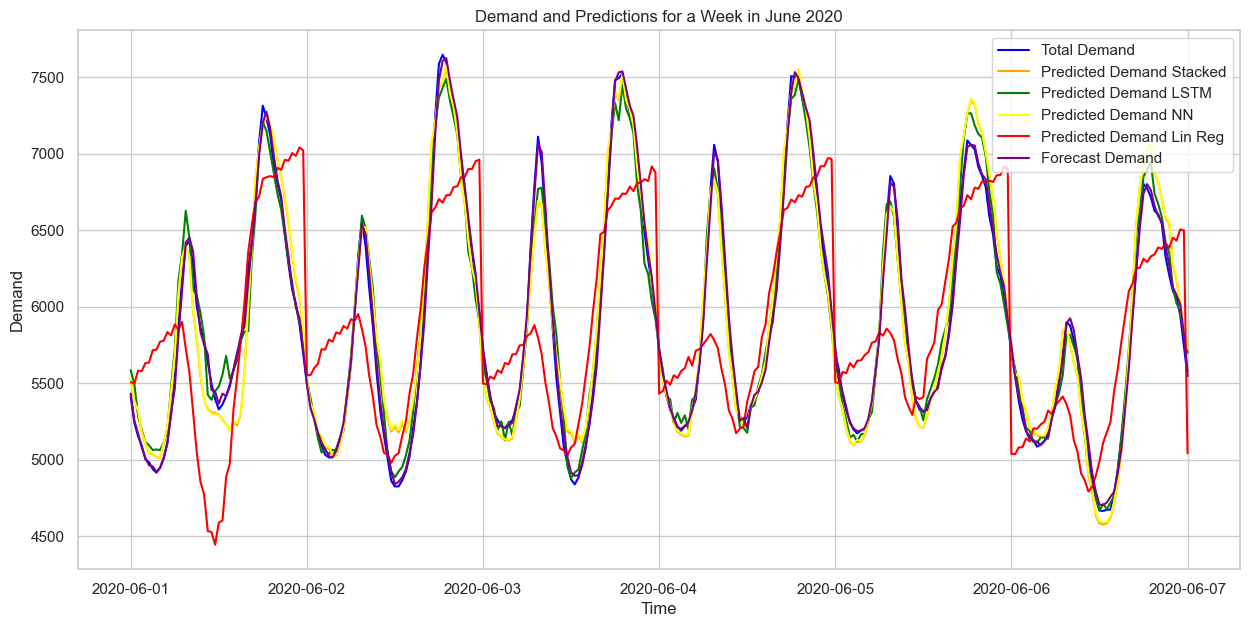

In [71]:
df_qld_merged['DATETIME'] = pd.to_datetime(df_qld_merged['DATETIME'])
weekly_data = complete_merged_df[(df_qld_merged['DATETIME'] >= '2020-06-01') & (df_qld_merged['DATETIME'] <= '2020-06-07')]

weekly_data = weekly_data.dropna(subset=['TOTALDEMAND', 'Stacked_Prediction', 'LSTM_Prediction', 'MLP_Prediction', 'FORECASTDEMAND','Lin_Reg_Prediction'])

dates = weekly_data['DATETIME'].to_numpy()
total_demand = weekly_data['TOTALDEMAND'].to_numpy()
predicted_stacked = weekly_data['Stacked_Prediction'].to_numpy()
predicted_lstm = weekly_data['LSTM_Prediction'].to_numpy()
predicted_nn = weekly_data['MLP_Prediction'].to_numpy()
predicted_lin_reg = weekly_data['Lin_Reg_Prediction'].to_numpy()
forecast_demand = weekly_data['FORECASTDEMAND'].to_numpy()

plt.figure(figsize=(15, 7))
plt.plot(dates, total_demand, color='blue', label='Total Demand')
plt.plot(dates, predicted_stacked, color='orange', label='Predicted Demand Stacked')
plt.plot(dates, predicted_lstm, color='green', label='Predicted Demand LSTM')
plt.plot(dates, predicted_nn, color='yellow', label='Predicted Demand NN')
plt.plot(dates, predicted_lin_reg, color='red', label='Predicted Demand Lin Reg')
plt.plot(dates, forecast_demand, color='purple', label='Forecast Demand')

plt.xlabel('Time')
plt.ylabel('Demand')
plt.title('Demand and Predictions for a Week in June 2020')
plt.legend()
plt.show()


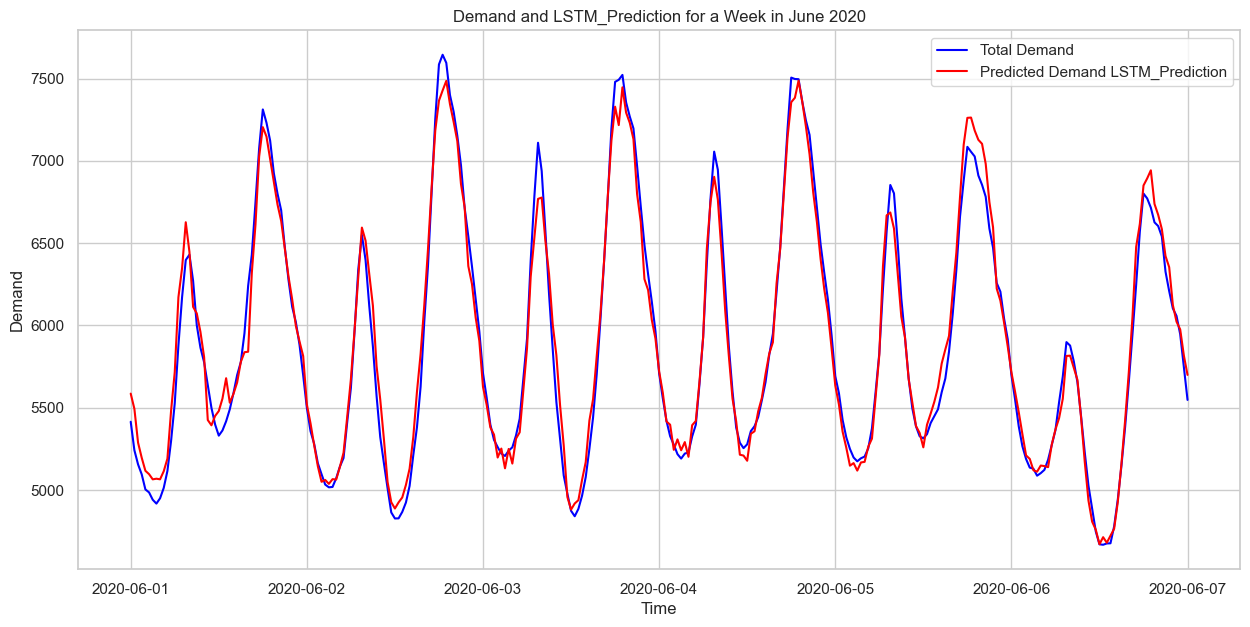

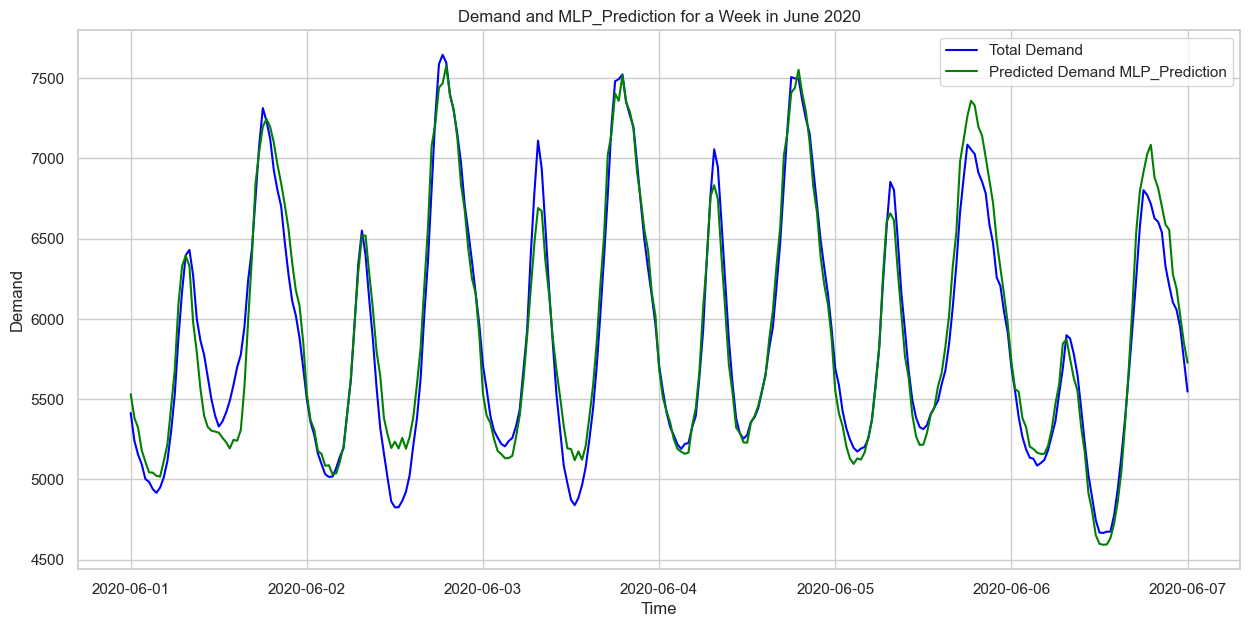

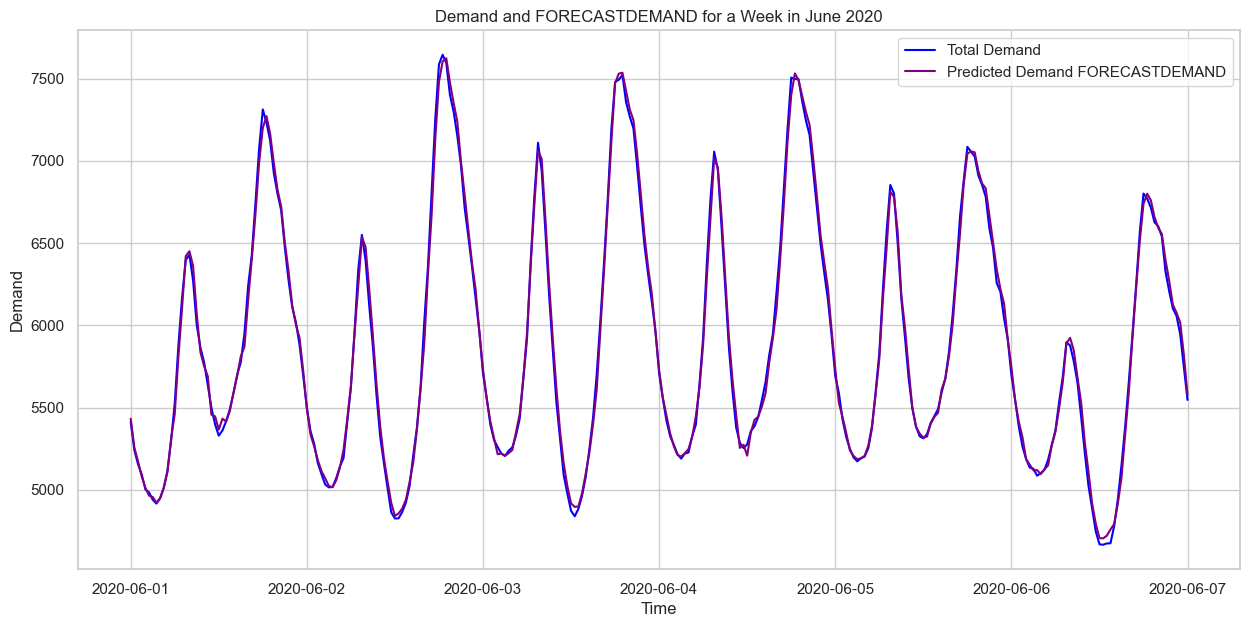

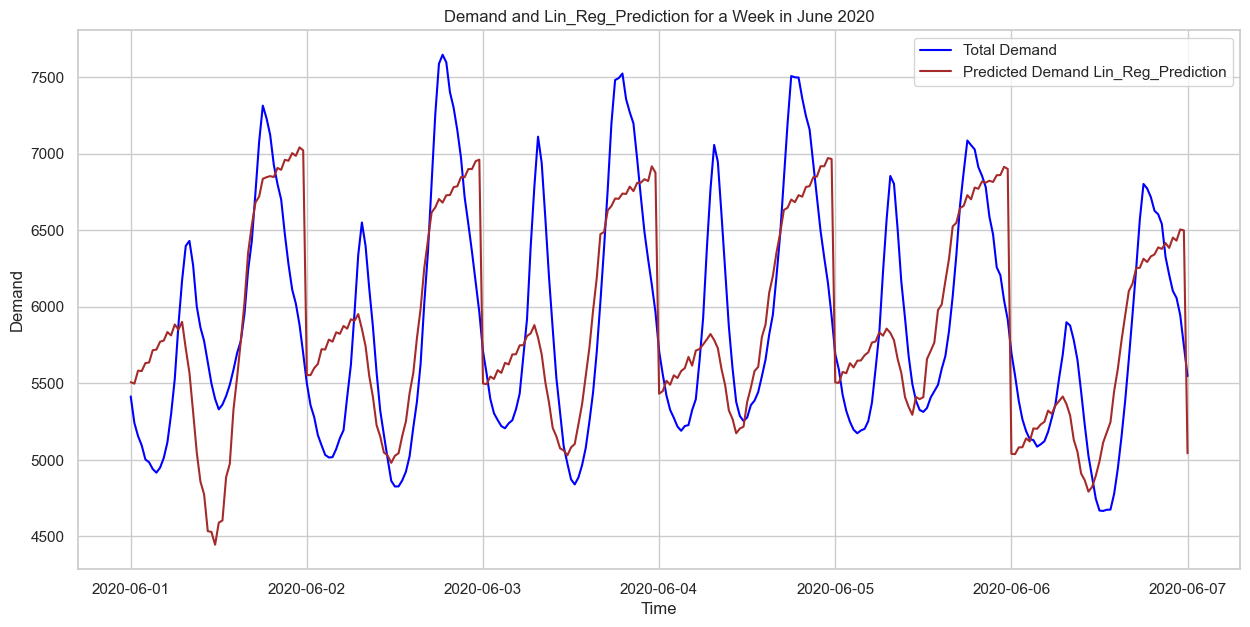

In [86]:
prediction_columns = ['LSTM_Prediction', 'MLP_Prediction', 'FORECASTDEMAND', 'Lin_Reg_Prediction']

colors = ['red', 'green', 'purple', 'brown']

weekly_data = complete_merged_df[(complete_merged_df['DATETIME'] >= '2020-06-01') & (complete_merged_df['DATETIME'] <= '2020-06-07')]
weekly_data = weekly_data.dropna(subset=['TOTALDEMAND'] + prediction_columns)

dates = weekly_data['DATETIME'].to_numpy()
total_demand = weekly_data['TOTALDEMAND'].to_numpy()

for i, pred_col in enumerate(prediction_columns):
    predicted_values = weekly_data[pred_col].to_numpy()

    plt.figure(figsize=(15, 7))
    plt.plot(dates, total_demand, color='blue', label='Total Demand')
    plt.plot(dates, predicted_values, color=colors[i % len(colors)], label=f'Predicted Demand {pred_col}')

    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.title(f'Demand and {pred_col} for a Week in June 2020')
    plt.legend()
    plt.show()


/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_18194/1394979441.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(new_labels, rotation=45, ha="center")


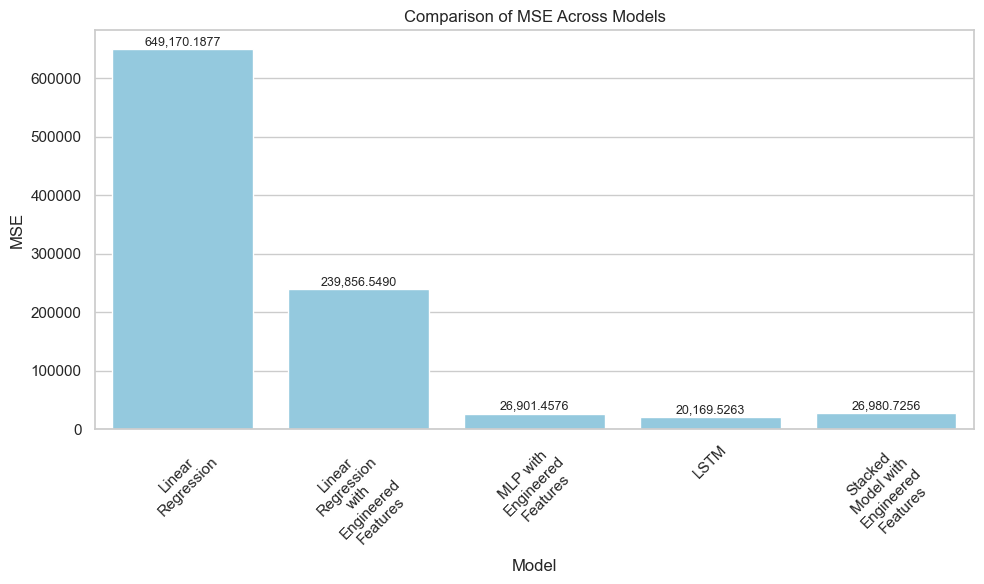

/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_18194/1394979441.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(new_labels, rotation=45, ha="center")


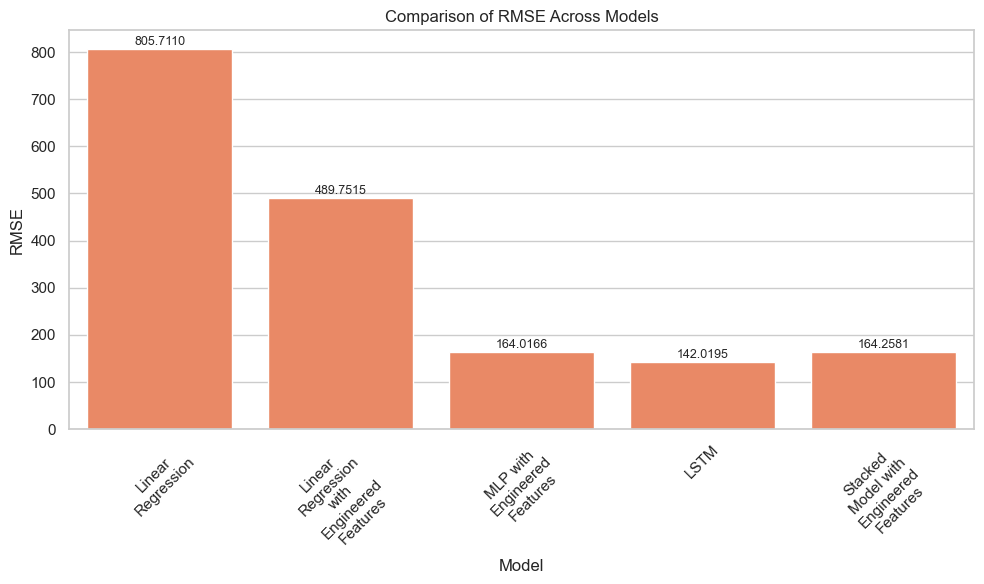

/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_18194/1394979441.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(new_labels, rotation=45, ha="center")


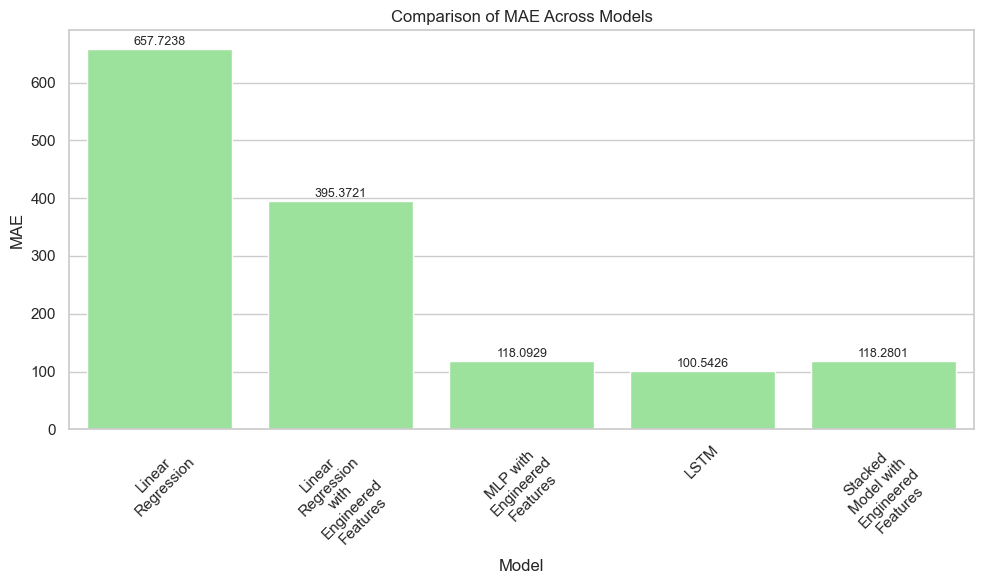

/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_18194/1394979441.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(new_labels, rotation=45, ha="center")


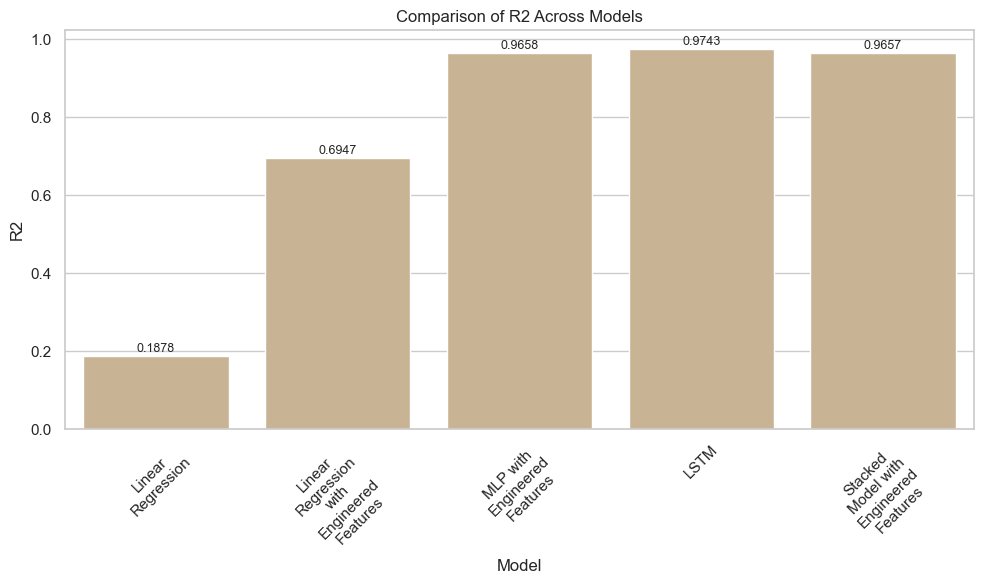

In [83]:
sns.set(style="whitegrid")

metrics = ['MSE', 'RMSE', 'MAE', 'R2']

colors = ['skyblue', 'coral', 'lightgreen', 'tan']

for i, metric in enumerate(metrics):
    
    plt.figure(figsize=(10, 6))
    
    current_color = colors[i % len(colors)]
    barplot = sns.barplot(data=metrics_df, x='Model', y=metric, color=current_color)

    
    plt.title(f'Comparison of {metric} Across Models')
    plt.ylabel(metric)
    plt.xlabel('Model')

    
    new_labels = ['\n'.join(textwrap.wrap(label.get_text(), 12)) for label in barplot.get_xticklabels()]

    
    barplot.set_xticklabels(new_labels, rotation=45, ha="center")

    
    for p in barplot.patches:
        height = p.get_height()
        barplot.annotate(f'{height:,.4f}',  
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center',
                         size=9,
                         xytext=(0, 5),
                         textcoords='offset points')

    
    plt.tight_layout()
    plt.show()
